<a href="https://colab.research.google.com/github/nebaraka/dissertation/blob/main/Dissertation_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import tensorflow_hub as hub

In [3]:
import os

In [4]:
import zipfile

In [5]:
import re

In [6]:
from skimage.transform import rescale, resize

In [7]:
import numpy as np
import pandas as pd

In [8]:
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras import Sequential
from keras.callbacks import TensorBoard
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

In [87]:
from keras.layers import Reshape

In [26]:
import IPython.display as display

In [110]:
import datetime

In [9]:
# with zipfile.ZipFile('drive/MyDrive/In-shop Clothes Retrieval Benchmark/Img/img.zip', 'r') as zip_ref:
#      zip_ref.extractall('img')

In [10]:
PATH = 'img/img/WOMEN/'

In [14]:
labels = os.listdir(PATH)

In [19]:
a = np.zeros(len(labels))

In [16]:
l_to_n = {}

In [17]:
for i in range(len(labels)):
  num = np.zeros(len(labels))
  num[i] = 1
  l_to_n[labels[i]] = num

In [23]:
%%time
X = []
Y = []
for folder in os.listdir(PATH):
  for subfolder in os.listdir(PATH + folder):
    for img in os.listdir(PATH + folder + '/' + subfolder):
      if bool(re.fullmatch(".*front.*", img)):
          X.append(resize(tf.image.convert_image_dtype(tf.image.decode_jpeg(
              tf.io.read_file(PATH + folder + '/' + subfolder + '/' + img)), tf.float32), (224, 224, 3),
                       anti_aliasing=True))
          Y.append(l_to_n[folder])
          break

CPU times: user 1min 46s, sys: 2min 22s, total: 4min 9s
Wall time: 2min 8s


In [102]:
%load_ext tensorboard

In [111]:
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [28]:
num_classes = 14

In [114]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
                   trainable=True),  # Can be True, see below.
    # tf.keras.layers.Dense(1664, activation='relu'),
    # tf.keras.layers.Dense(1664, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])  # Batch input shape.

In [ ]:
del model

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [31]:
del X
del Y

In [42]:
X_train = np.array(X_train)

In [43]:
Y_train = np.array(Y_train)

In [118]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [119]:
N_EPOCHS = 100

In [ ]:
summary = model.fit(X_train, Y_train,
                    batch_size=35,
                    epochs=N_EPOCHS, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[tensorboard_callback])

Epoch 1/100
181/181 [==============================] - 67s 299ms/step - loss: 0.2895 - val_loss: 0.2956
Epoch 2/100
181/181 [==============================] - 54s 298ms/step - loss: 0.2110 - val_loss: 0.3154
Epoch 3/100
181/181 [==============================] - 55s 301ms/step - loss: 0.1918 - val_loss: 0.2267
Epoch 4/100
181/181 [==============================] - 55s 304ms/step - loss: 0.1724 - val_loss: 0.2446
Epoch 5/100
181/181 [==============================] - 54s 300ms/step - loss: 0.1617 - val_loss: 0.2295
Epoch 6/100
181/181 [==============================] - 54s 299ms/step - loss: 0.1503 - val_loss: 0.2205
Epoch 7/100
181/181 [==============================] - 55s 303ms/step - loss: 0.1435 - val_loss: 0.2602
Epoch 8/100
181/181 [==============================] - 57s 314ms/step - loss: 0.1372 - val_loss: 0.2156
Epoch 9/100
181/181 [==============================] - 57s 314ms/step - loss: 0.1291 - val_loss: 0.2320
Epoch 10/100
181/181 [==============================] - 58s 319m

In [ ]:
%tensorboard --logdir logs

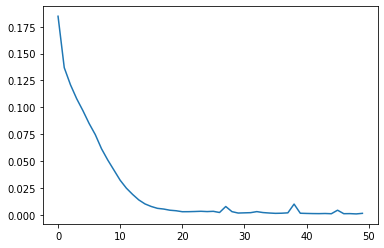

In [95]:
plt.plot(summary.history['loss'])

In [51]:
X_test = np.array(X_test)

In [66]:
Y_test = np.array(Y_test)

In [96]:
del Y_pred
Y_pred = model.predict(X_test)

In [97]:
sklearn.metrics.f1_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), average='macro')

0.5152046641873149

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1664)              3766048   
_________________________________________________________________
dense (Dense)                (None, 14)                23310     
Total params: 3,789,358
Trainable params: 23,310
Non-trainable params: 3,766,048
_________________________________________________________________
